<a href="https://colab.research.google.com/github/pkrishna1801/Image2Text/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xrays-indiana-university


## Dataset

In [3]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

# Load your CSV files
projections_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')
reports_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Merge the dataframes on UID
merged_df = pd.merge(projections_df, reports_df, on='uid')

# # Create a custom dataset class
# class ChestXrayDataset(Dataset):
#     def __init__(self, dataframe, img_dir, transform=None):
#         self.dataframe = dataframe
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_name = self.dataframe.iloc[idx]['filename']
#         img_path = os.path.join(self.img_dir, img_name)
#         image = Image.open(img_path).convert('RGB')

#         if self.transform:
#             image = self.transform(image)

#         # Combine findings and impression for the report text
#         findings = self.dataframe.iloc[idx]['findings']
#         impression = self.dataframe.iloc[idx]['impression']
#         report_text = findings + " " + impression

#         return {
#             'image': image,
#             'report': report_text,
#             'uid': self.dataframe.iloc[idx]['uid']
#         }

In [44]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, img_dir, feature_extractor=None, tokenizer=None, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Combine findings and impression for the report text
        findings = self.dataframe.iloc[idx]['findings']
        findings = "" if pd.isna(findings) else str(findings)

        impression = self.dataframe.iloc[idx]['impression']
        impression = "" if pd.isna(impression) else str(impression)

        report_text = ""
        if findings != "":
            report_text += f"Findings: {findings} "
        if impression != "":
            report_text += f"Impression: {impression}"

        report_text = report_text.strip()

        # Process image with ViT feature extractor if available
        if self.feature_extractor:
            pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values.squeeze(0)
        elif self.transform:
            pixel_values = self.transform(image)
        else:
            # Default transform if none provided
            from torchvision import transforms
            default_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
            pixel_values = default_transform(image)

        # Process text with GPT-2 tokenizer if available
        if self.tokenizer:
            encoded_text = self.tokenizer(report_text, return_tensors="pt", padding="max_length",
                                         max_length=512, truncation=True)
            input_ids = encoded_text.input_ids.squeeze(0)
            attention_mask = encoded_text.attention_mask.squeeze(0)

            return {
                'pixel_values': pixel_values,
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'report': report_text,
                'uid': self.dataframe.iloc[idx]['uid']
            }

        return {
            'pixel_values': pixel_values,
            'report': report_text,
            'uid': self.dataframe.iloc[idx]['uid']
        }

In [ ]:
# class ChestXrayDataset(Dataset):
#     def __init__(self, dataframe, img_dir, transform=None):
#         self.dataframe = dataframe
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_name = self.dataframe.iloc[idx]['filename']
#         img_path = os.path.join(self.img_dir, img_name)
#         image = Image.open(img_path).convert('RGB')

#         if self.transform:
#             image = self.transform(image)

#         # Handle NaN values in text fields
#         findings = self.dataframe.iloc[idx]['findings']
#         findings = "" if pd.isna(findings) else str(findings)

#         impression = self.dataframe.iloc[idx]['impression']
#         impression = "" if pd.isna(impression) else str(impression)

#         # If both are empty, try to use other fields
#         if findings == "" and impression == "":
#             # Try to use 'Problems' field or other available fields
#             problems = self.dataframe.iloc[idx]['Problems']
#             problems = "" if pd.isna(problems) else str(problems)

#             # Construct a simple report if we have some information
#             if problems != "":
#                 report_text = f"Problems: {problems}"
#             else:
#                 # Default text if no information is available
#                 report_text = "No report information available"
#         else:
#             # Combine findings and impression
#             report_text = ""
#             if findings != "":
#                 report_text += f"Findings: {findings} "
#             if impression != "":
#                 report_text += f"Impression: {impression}"

#         return {
#             'image': image,
#             'report': report_text.strip(),
#             'uid': self.dataframe.iloc[idx]['uid']
#         }

In [5]:
# Check for missing values
print("Missing values in each column:")
print(merged_df.isna().sum())

# Filter out rows with missing critical data
valid_data = merged_df.dropna(subset=['findings', 'impression'])
print(f"Records with complete reports: {len(valid_data)} out of {len(merged_df)}")

Missing values in each column:
uid              0
filename         0
projection       0
MeSH             0
Problems         0
image            0
indication     159
comparison    2260
findings       997
impression      52
dtype: int64
Records with complete reports: 6457 out of 7466


In [6]:
merged_df

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
...,...,...,...,...,...,...,...,...,...,...
7461,3997,3997_IM-2048-1002.dcm.png,Lateral,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB."
7462,3998,3998_IM-2048-1001.dcm.png,Frontal,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.
7463,3998,3998_IM-2048-1002.dcm.png,Lateral,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.
7464,3999,3999_IM-2049-1001.dcm.png,Frontal,normal,normal,"CHEST PA and LATERAL: on XXXX, XXXX.",This is a XXXX-year-old female patient with sh...,"Chest x-XXXX, XXXX, XXXX.",NaN,The cardiac silhouette is normal in size and c...


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader

# 2. Use your ViTGPT2Model class
class ViTGPT2Model(nn.Module):
    def __init__(self):
        super(ViTGPT2Model, self).__init__()

        # Load pre-trained ViT
        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224')

        # Load pre-trained GPT-2
        self.gpt2_config = GPT2Config.from_pretrained('gpt2')
        self.gpt2_config.add_cross_attention = True
        self.text_decoder = GPT2LMHeadModel.from_pretrained('gpt2', config=self.gpt2_config)

    def forward(self, pixel_values, input_ids, attention_mask=None):
        # Encode image
        vision_outputs = self.image_encoder(pixel_values=pixel_values)
        image_features = vision_outputs.last_hidden_state

        # Decode text with image features as encoder_hidden_states
        text_outputs = self.text_decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=image_features,
            return_dict=True
        )

        return text_outputs.logits

In [61]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(valid_data, test_size=0.2, random_state=42)


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
from torchvision import transforms

# For training data
train_transform = transforms.Compose([
    # Resize images to a standard size required by most CNN/ViT architectures
    transforms.Resize((224, 224)),

    # Apply mild random transformations for data augmentation
    # Limited rotation (±5 degrees) to preserve medical features
    # Small translations (5% max) and scaling (±5%)
    transforms.RandomAffine(
        degrees=5,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),

    # Random horizontal flip (if appropriate for your medical context)
    # Note: For some medical images, this might not be appropriate
    transforms.RandomHorizontalFlip(p=0.5),

    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),

    # Normalize pixel values to the range expected by pre-trained models
    # These values are ImageNet means/stds, you might want to calculate
    # dataset-specific values for better performance
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# For validation/testing (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
def generate_report(model, image, tokenizer, max_length=150):
    model.eval()

    # Prepare image
    image = image.unsqueeze(0).to(device)

    # Start with the [CLS] token
    current_ids = torch.tensor([[tokenizer.cls_token_id]]).to(device)
    current_mask = torch.ones_like(current_ids).to(device)

    generated_ids = []

    for _ in range(max_length):
        # Forward pass
        with torch.no_grad():
            outputs = model(image, current_ids, current_mask)
            next_token_logits = outputs[:, -1, :]

        # Get the most likely next token
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)

        # Break if end of sequence
        if next_token.item() == tokenizer.sep_token_id:
            break

        # Add the token to our sequence
        generated_ids.append(next_token.item())
        current_ids = torch.cat([current_ids, next_token], dim=1)
        current_mask = torch.ones_like(current_ids)

    # Decode the sequence
    report = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return report

In [ ]:
from transformers import BertTokenizer
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)



tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# GPT-2 doesn't have padding token by default, so let's add one
tokenizer.pad_token = tokenizer.eos_token
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Prepare data loaders
train_dataset = ChestXrayDataset(
    train_df,
    '/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
    feature_extractor=feature_extractor,
    tokenizer=tokenizer
)

val_dataset = ChestXrayDataset(
    val_df,
    '/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
    feature_extractor=feature_extractor,
    tokenizer=tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Smaller batch size for larger model
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
model = ViTGPT2Model()
model = model.to(device)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)  # Using AdamW for transformer models

# Training loop
num_epochs = 20
best_val_loss = float('inf')



resume_training = True  # Set to True when you want to resume
checkpoint_path = 'checkpoints/checkpoint_epoch_1.pth'  # Replace X with the epoch number

if resume_training:
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        print(f'Resuming from epoch {start_epoch} with validation loss: {checkpoint["val_loss"]:.4f}')
    else:
        print(f'No checkpoint found at {checkpoint_path}, starting from scratch')
        start_epoch = 0
        best_val_loss = float('inf')
else:
    start_epoch = 0
    best_val_loss = float('inf')


for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in tqdm(train_loader):
        # Move everything to device
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # For GPT-2 autoregressive training, we shift the inputs right
        labels = input_ids.clone()
        # Ignore padding tokens for loss calculation
        labels[labels == tokenizer.pad_token_id] = -100

        # Forward pass
        outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)

        # Calculate loss (GPT-2 uses a shift in the logits)
        # Shift logits so they are aligned with labels
        shift_logits = outputs[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            labels = input_ids.clone()
            labels[labels == tokenizer.pad_token_id] = -100

            outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)

            shift_logits = outputs[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

            val_loss += loss.item()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Save regular checkpoint every N epochs
    if (epoch + 1) % 1 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')

    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'best_val_loss': best_val_loss,
        }, best_model_path)
        print(f'Best model saved with validation loss: {avg_val_loss:.4f}')

# Final model save
final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')
torch.save(model.state_dict(), final_model_path)
print(f'Final model saved: {final_model_path}')

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

Resuming from epoch 1 with validation loss: 1.1722


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 1/20, Train Loss: 1.1297, Val Loss: 1.0170
Checkpoint saved: checkpoints/checkpoint_epoch_1.pth
Best model saved with validation loss: 1.0170


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 2/20, Train Loss: 0.9742, Val Loss: 0.9056
Checkpoint saved: checkpoints/checkpoint_epoch_2.pth
Best model saved with validation loss: 0.9056


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 3/20, Train Loss: 0.8633, Val Loss: 0.8306
Checkpoint saved: checkpoints/checkpoint_epoch_3.pth
Best model saved with validation loss: 0.8306


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 4/20, Train Loss: 0.7678, Val Loss: 0.7747
Checkpoint saved: checkpoints/checkpoint_epoch_4.pth
Best model saved with validation loss: 0.7747


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 5/20, Train Loss: 0.6846, Val Loss: 0.7320
Checkpoint saved: checkpoints/checkpoint_epoch_5.pth
Best model saved with validation loss: 0.7320


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 6/20, Train Loss: 0.6094, Val Loss: 0.6910
Checkpoint saved: checkpoints/checkpoint_epoch_6.pth
Best model saved with validation loss: 0.6910


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 7/20, Train Loss: 0.5342, Val Loss: 0.6636
Checkpoint saved: checkpoints/checkpoint_epoch_7.pth
Best model saved with validation loss: 0.6636


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 8/20, Train Loss: 0.4737, Val Loss: 0.6238
Checkpoint saved: checkpoints/checkpoint_epoch_8.pth
Best model saved with validation loss: 0.6238


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 9/20, Train Loss: 0.4099, Val Loss: 0.6090
Checkpoint saved: checkpoints/checkpoint_epoch_9.pth
Best model saved with validation loss: 0.6090


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 10/20, Train Loss: 0.3550, Val Loss: 0.5993
Checkpoint saved: checkpoints/checkpoint_epoch_10.pth
Best model saved with validation loss: 0.5993


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 11/20, Train Loss: 0.3078, Val Loss: 0.5931
Checkpoint saved: checkpoints/checkpoint_epoch_11.pth
Best model saved with validation loss: 0.5931


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 12/20, Train Loss: 0.2634, Val Loss: 0.5819
Checkpoint saved: checkpoints/checkpoint_epoch_12.pth
Best model saved with validation loss: 0.5819


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 13/20, Train Loss: 0.2287, Val Loss: 0.5792
Checkpoint saved: checkpoints/checkpoint_epoch_13.pth
Best model saved with validation loss: 0.5792


100%|██████████| 81/81 [02:06<00:00,  1.57s/it]


Epoch 14/20, Train Loss: 0.2027, Val Loss: 0.5764
Checkpoint saved: checkpoints/checkpoint_epoch_14.pth
Best model saved with validation loss: 0.5764


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


Epoch 15/20, Train Loss: 0.1699, Val Loss: 0.5880
Checkpoint saved: checkpoints/checkpoint_epoch_15.pth


100%|██████████| 81/81 [02:08<00:00,  1.58s/it]


Epoch 16/20, Train Loss: 0.1453, Val Loss: 0.5945
Checkpoint saved: checkpoints/checkpoint_epoch_16.pth


100%|██████████| 81/81 [02:08<00:00,  1.58s/it]


Epoch 17/20, Train Loss: 0.1307, Val Loss: 0.6046
Checkpoint saved: checkpoints/checkpoint_epoch_17.pth


100%|██████████| 81/81 [02:08<00:00,  1.58s/it]


Epoch 18/20, Train Loss: 0.1081, Val Loss: 0.6340
Checkpoint saved: checkpoints/checkpoint_epoch_18.pth


100%|██████████| 81/81 [02:08<00:00,  1.58s/it]


Epoch 19/20, Train Loss: 0.0896, Val Loss: 0.6348
Checkpoint saved: checkpoints/checkpoint_epoch_19.pth


100%|██████████| 81/81 [02:08<00:00,  1.58s/it]


Epoch 20/20, Train Loss: 0.0768, Val Loss: 0.6725
Checkpoint saved: checkpoints/checkpoint_epoch_20.pth
Final model saved: checkpoints/final_model.pth


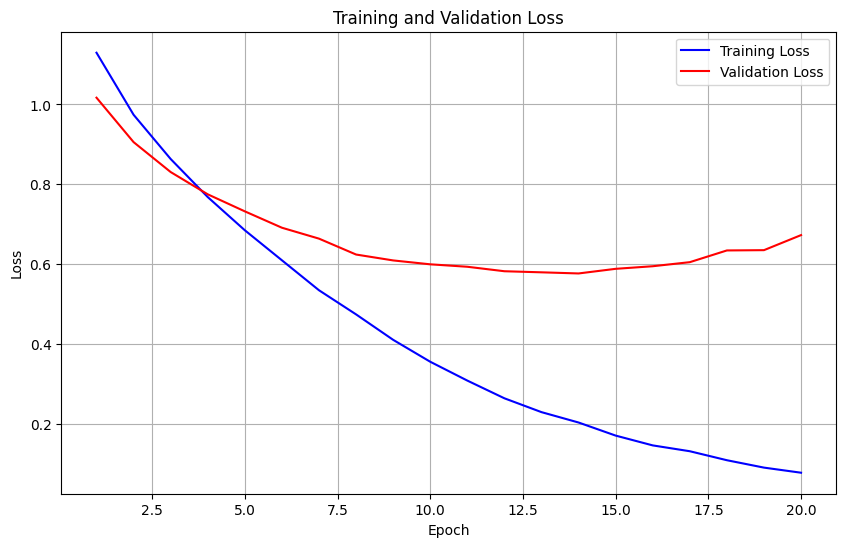

In [10]:
import matplotlib.pyplot as plt
import os
import torch
import json
import glob

def extract_and_plot_losses_from_checkpoints(checkpoint_dir='checkpoints'):
    # Find all checkpoint files
    checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth')))

    if not checkpoint_files:
        print(f"No checkpoint files found in {checkpoint_dir}")
        return

    # Extract training and validation losses
    epochs = []
    train_losses = []
    val_losses = []

    for checkpoint_file in checkpoint_files:
        checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))

        # Extract epoch number from filename
        epoch_num = int(os.path.basename(checkpoint_file).split('_')[-1].split('.')[0])
        epochs.append(epoch_num)

        # Extract losses from checkpoint
        if 'train_loss' in checkpoint and 'val_loss' in checkpoint:
            train_losses.append(checkpoint['train_loss'])
            val_losses.append(checkpoint['val_loss'])
        else:
            print(f"Checkpoint {checkpoint_file} doesn't contain loss information")

    # Sort by epoch (just in case filenames aren't sorted correctly)
    sorted_data = sorted(zip(epochs, train_losses, val_losses))
    epochs, train_losses, val_losses = zip(*sorted_data)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_path = os.path.join(checkpoint_dir, 'loss_plot.png')
    plt.savefig(plot_path)

    # Also save the metrics as JSON for future reference
    metrics = {
        'epochs': epochs,
        'train_loss': train_losses,
        'val_loss': val_losses
    }

    metrics_path = os.path.join(checkpoint_dir, 'extracted_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

    # print(f"Metrics saved to {metrics_path}")

    return metrics

# Call the function
metrics = extract_and_plot_losses_from_checkpoints()

In [63]:
from transformers import BertTokenizer
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)



tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# GPT-2 doesn't have padding token by default, so let's add one
tokenizer.pad_token = tokenizer.eos_token
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
val_dataset = ChestXrayDataset(
    val_df,
    '/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
    feature_extractor=feature_extractor,
    tokenizer=tokenizer
)


val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [64]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import random

def generate_report(model, image, tokenizer, max_length=150):
    model.eval()

    # Prepare image
    image = image.unsqueeze(0).to(device)

    # For GPT-2, use the BOS (beginning of sequence) token
    # GPT-2 doesn't have a CLS token like BERT
    current_ids = torch.tensor([[tokenizer.bos_token_id]]).to(device)
    current_mask = torch.ones_like(current_ids).to(device)

    generated_ids = []

    for _ in range(max_length):
        # Forward pass
        with torch.no_grad():
            outputs = model(image, current_ids, current_mask)
            next_token_logits = outputs[:, -1, :]

        # Get the most likely next token
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)

        # Break if end of sequence
        if next_token.item() == tokenizer.eos_token_id:
            break

        # Add the token to our sequence
        generated_ids.append(next_token.item())
        current_ids = torch.cat([current_ids, next_token], dim=1)
        current_mask = torch.ones_like(current_ids)

    # Decode the sequence
    report = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return report

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

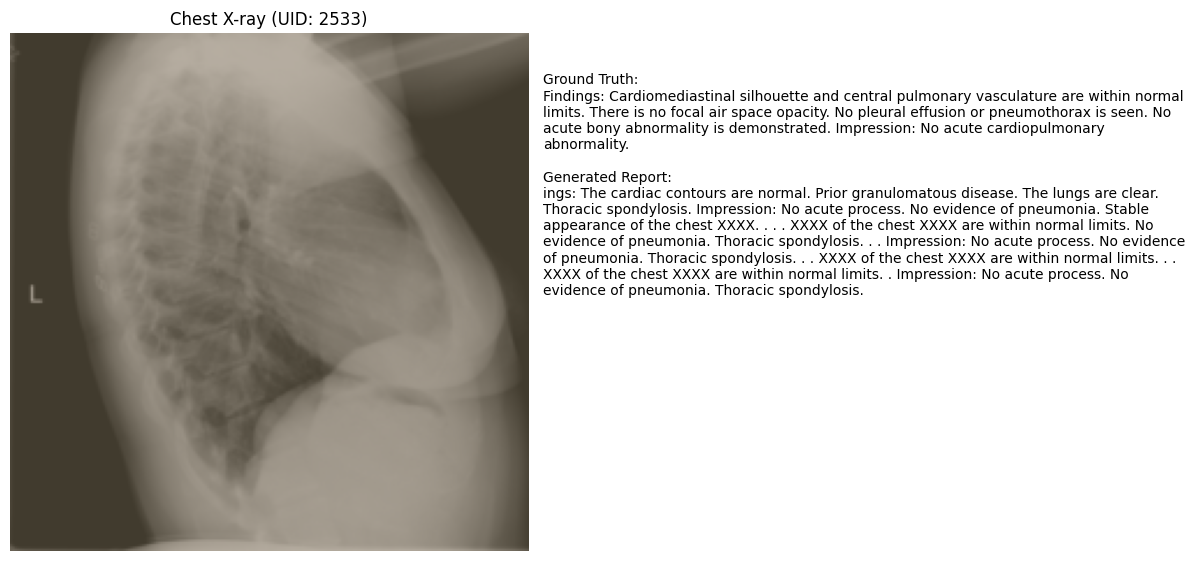

Sample 95, UID: 2533
Ground Truth Report:
Findings: Cardiomediastinal silhouette and central pulmonary vasculature are within normal limits. There is no focal air space opacity. No pleural effusion or pneumothorax is seen. No acute bony abnormality is demonstrated. Impression: No acute cardiopulmonary abnormality.

Generated Report:
ings: The cardiac contours are normal. Prior granulomatous disease. The lungs are clear. Thoracic spondylosis. Impression: No acute process. No evidence of pneumonia. Stable appearance of the chest XXXX. . . . XXXX of the chest XXXX are within normal limits. No evidence of pneumonia. Thoracic spondylosis. . . Impression: No acute process. No evidence of pneumonia. Thoracic spondylosis. . . XXXX of the chest XXXX are within normal limits. . . XXXX of the chest XXXX are within normal limits. . Impression: No acute process. No evidence of pneumonia. Thoracic spondylosis.
--------------------------------------------------------------------------------


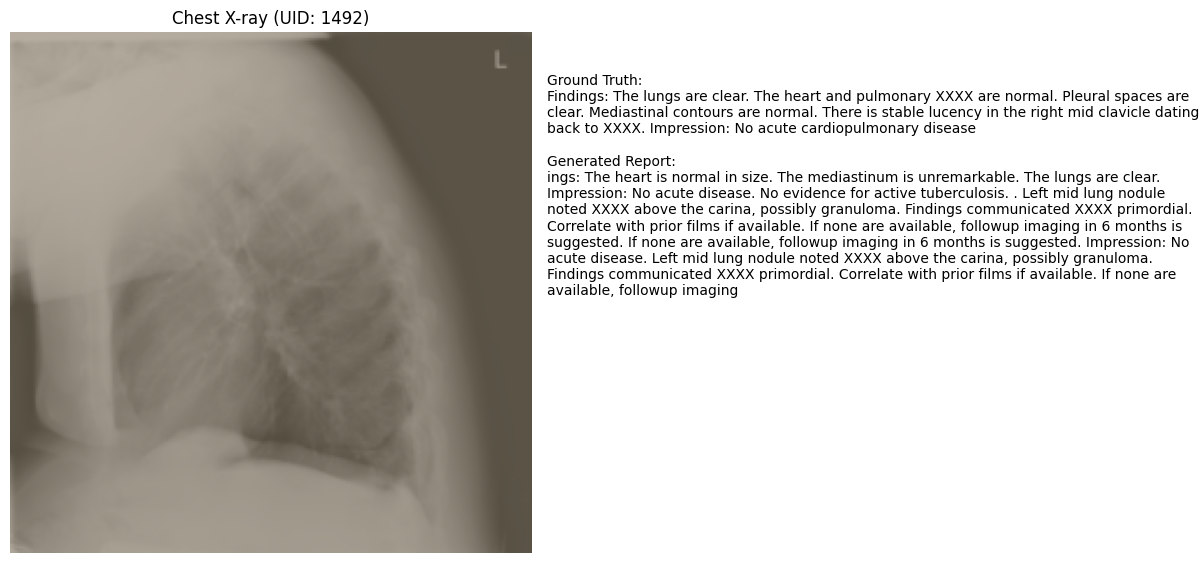

Sample 212, UID: 1492
Ground Truth Report:
Findings: The lungs are clear. The heart and pulmonary XXXX are normal. Pleural spaces are clear. Mediastinal contours are normal. There is stable lucency in the right mid clavicle dating back to XXXX. Impression: No acute cardiopulmonary disease

Generated Report:
ings: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear. Impression: No acute disease. No evidence for active tuberculosis. . Left mid lung nodule noted XXXX above the carina, possibly granuloma. Findings communicated XXXX primordial. Correlate with prior films if available. If none are available, followup imaging in 6 months is suggested. If none are available, followup imaging in 6 months is suggested. Impression: No acute disease. Left mid lung nodule noted XXXX above the carina, possibly granuloma. Findings communicated XXXX primordial. Correlate with prior films if available. If none are available, followup imaging
-------------------------------

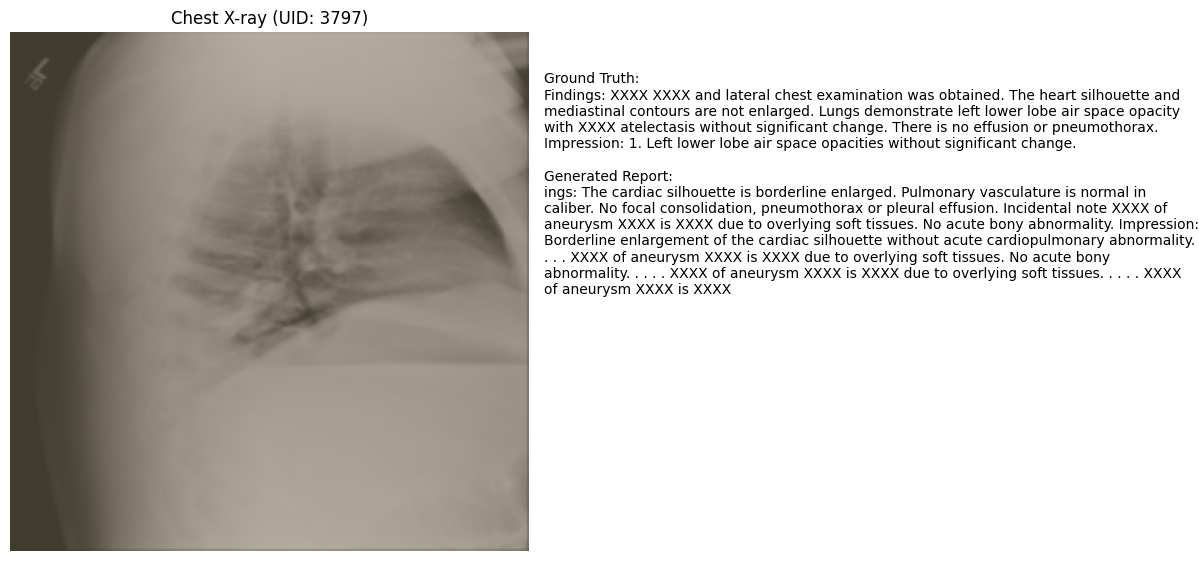

Sample 1161, UID: 3797
Ground Truth Report:
Findings: XXXX XXXX and lateral chest examination was obtained. The heart silhouette and mediastinal contours are not enlarged. Lungs demonstrate left lower lobe air space opacity with XXXX atelectasis without significant change. There is no effusion or pneumothorax. Impression: 1. Left lower lobe air space opacities without significant change.

Generated Report:
ings: The cardiac silhouette is borderline enlarged. Pulmonary vasculature is normal in caliber. No focal consolidation, pneumothorax or pleural effusion. Incidental note XXXX of aneurysm XXXX is XXXX due to overlying soft tissues. No acute bony abnormality. Impression: Borderline enlargement of the cardiac silhouette without acute cardiopulmonary abnormality. . . . XXXX of aneurysm XXXX is XXXX due to overlying soft tissues. No acute bony abnormality. . . . . XXXX of aneurysm XXXX is XXXX due to overlying soft tissues. . . . . XXXX of aneurysm XXXX is XXXX
--------------------------

In [13]:
def visualize_sample_predictions(model, val_dataset, tokenizer, sample_indices=None, max_length=150, device='cuda'):
    """
    Visualize specific examples from the validation set and compare model predictions with ground truth.

    Args:
        model: The trained ViTGPT2 model
        val_dataset: Validation dataset
        tokenizer: GPT-2 tokenizer
        sample_indices: List of indices to visualize (if None, picks 3 random samples)
        max_length: Maximum length of generated text
        device: Device to run inference on
    """
    model.eval()

    # Choose samples from validation set
    if sample_indices is None:
        num_samples = 3
        sample_indices = random.sample(range(len(val_dataset)), num_samples)

    for idx in sample_indices:
        sample = val_dataset[idx]

        # Get image and ground truth report
        image = sample['pixel_values'].to(device)
        ground_truth_report = sample['report']
        uid = sample['uid']

        # Generate report using model
        try:
            with torch.no_grad():
                generated_report = generate_report(model, image, tokenizer, max_length)

            # Display image
            img_tensor = image.cpu().permute(1, 2, 0)  # Change from CxHxW to HxWxC

            # Handle normalization - assuming standard ImageNet normalization
            img_tensor = img_tensor * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img_tensor = torch.clamp(img_tensor, 0, 1)

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(img_tensor.numpy())
            plt.title(f"Chest X-ray (UID: {uid})")
            plt.axis('off')

            # Display text comparison
            plt.subplot(1, 2, 2)
            plt.axis('off')
            comparison_text = f"Ground Truth:\n{ground_truth_report}\n\n"
            comparison_text += f"Generated Report:\n{generated_report}"
            plt.text(0, 0.5, comparison_text, fontsize=10, wrap=True)

            plt.tight_layout()
            plt.show()

            # Print the comparison for easier reading
            print(f"Sample {idx}, UID: {uid}")
            print("Ground Truth Report:")
            print(ground_truth_report)
            print("\nGenerated Report:")
            print(generated_report)
            print("-" * 80)

        except Exception as e:
            print(f"Error processing sample {idx}: {e}")

# Load the best model (assuming it's been saved)
best_model_path = 'checkpoints/best_model.pth'
model = ViTGPT2Model()
model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
model = model.to(device)

# Run the visualization function
visualize_sample_predictions(model, val_dataset, tokenizer)

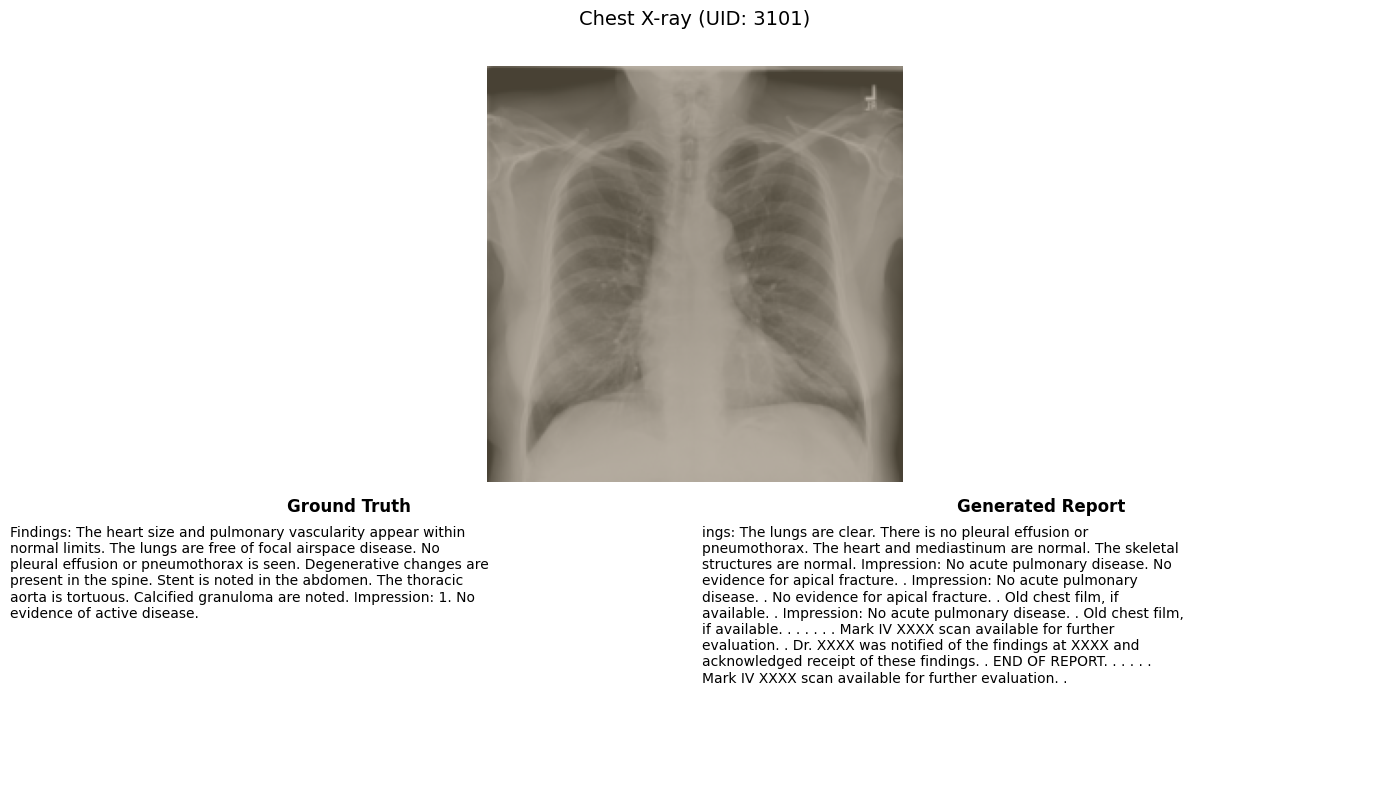

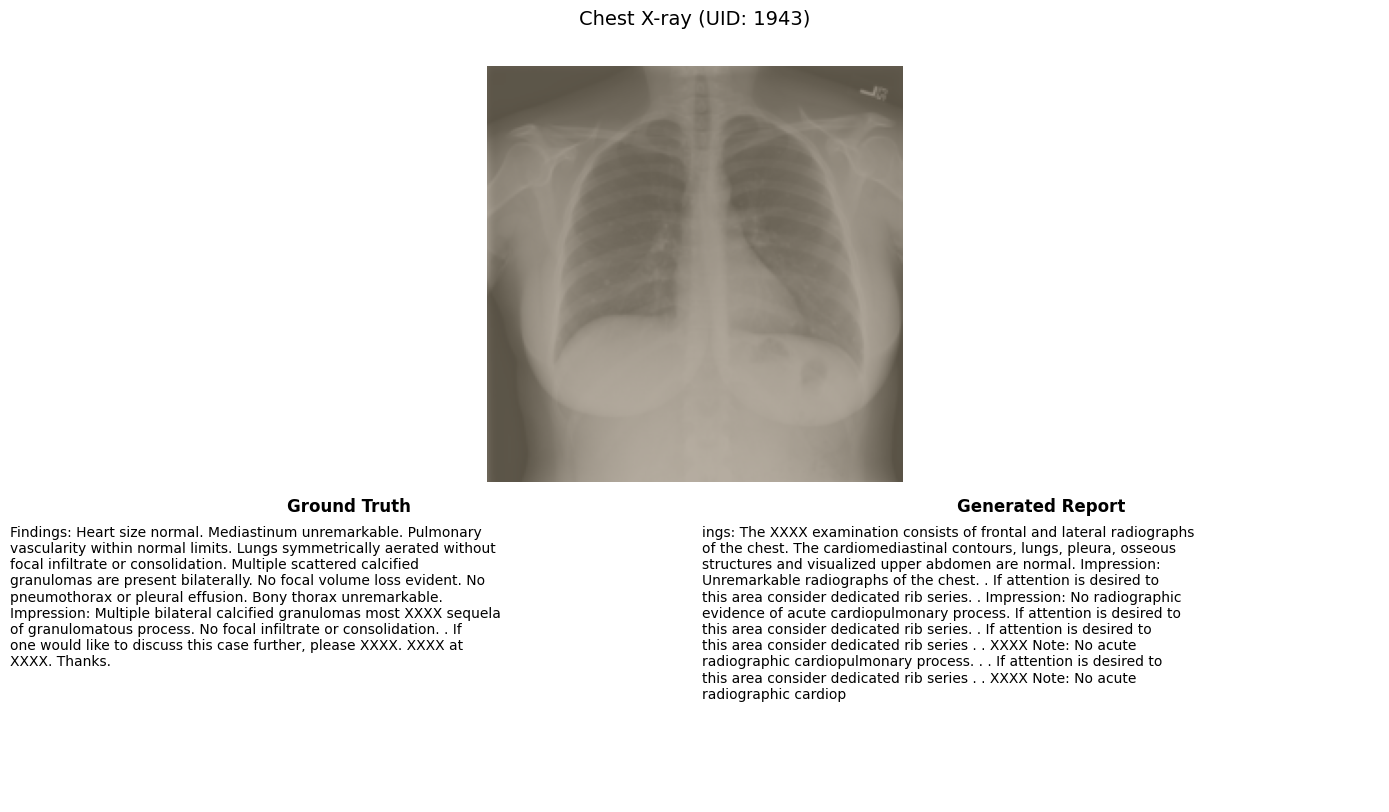

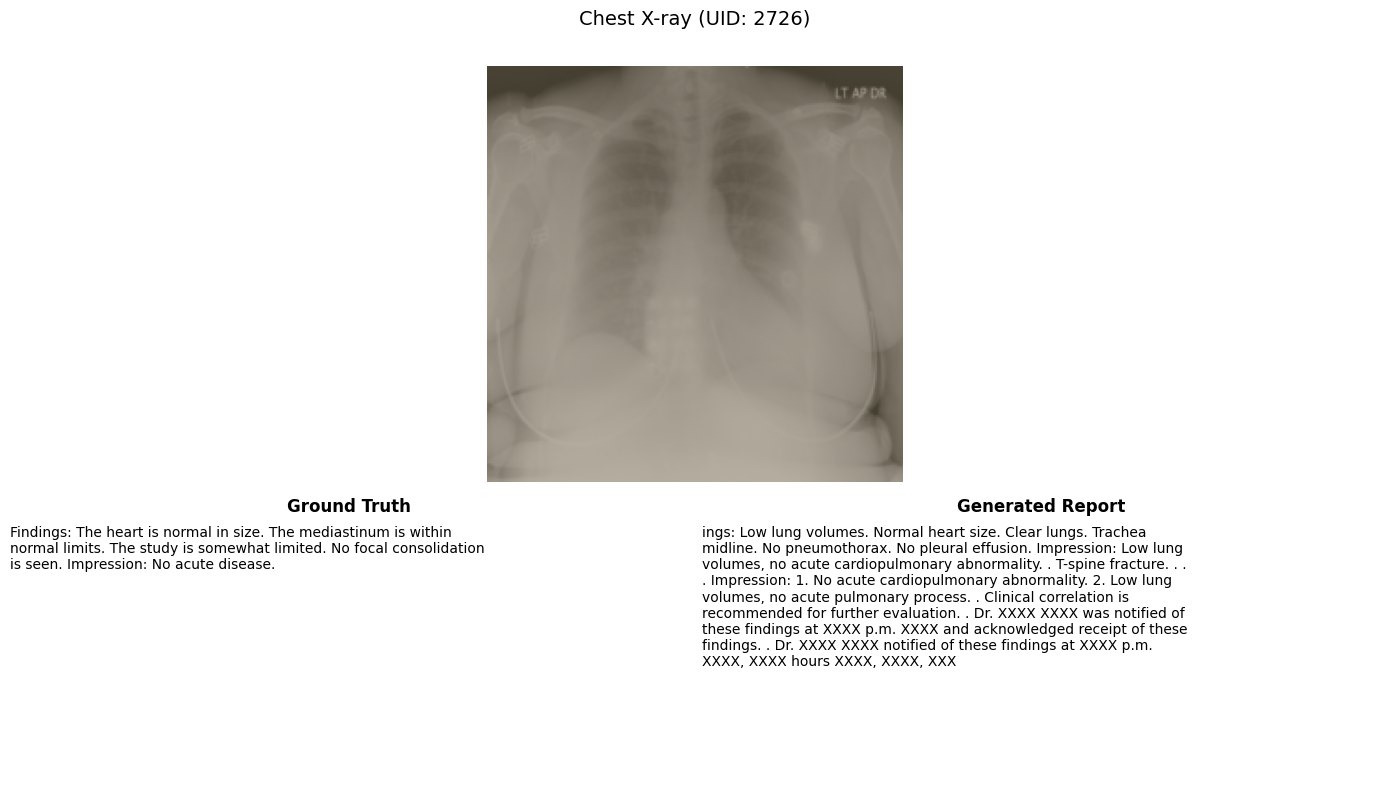

In [14]:
import textwrap

def visualize_sample_predictions_v2(model, val_dataset, tokenizer, sample_indices=None, max_length=150, device='cuda'):
    model.eval()

    if sample_indices is None:
        sample_indices = random.sample(range(len(val_dataset)), 3)

    for idx in sample_indices:
        sample = val_dataset[idx]
        image = sample['pixel_values'].to(device)
        ground_truth_report = sample['report']
        uid = sample['uid']

        try:
            with torch.no_grad():
                generated_report = generate_report(model, image, tokenizer, max_length)

            # Unnormalize
            img_tensor = image.cpu().permute(1, 2, 0)
            img_tensor = img_tensor * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img_tensor = torch.clamp(img_tensor, 0, 1)

            # Create figure
            fig = plt.figure(figsize=(14, 8))
            gs = fig.add_gridspec(2, 2, height_ratios=[3, 2])

            ax_img = fig.add_subplot(gs[0, :])
            ax_img.imshow(img_tensor.numpy())
            ax_img.axis('off')

            # Ground truth
            ax_gt = fig.add_subplot(gs[1, 0])
            ax_gt.axis('off')
            ax_gt.set_title('Ground Truth', fontsize=12, fontweight='bold', pad=10)
            gt_wrapped = "\n".join(textwrap.wrap(ground_truth_report, width=70))
            ax_gt.text(0, 1, gt_wrapped, fontsize=10, va='top')

            # Generated report
            ax_gen = fig.add_subplot(gs[1, 1])
            ax_gen.axis('off')
            ax_gen.set_title('Generated Report', fontsize=12, fontweight='bold', pad=10)
            gen_wrapped = "\n".join(textwrap.wrap(generated_report, width=70))
            ax_gen.text(0, 1, gen_wrapped, fontsize=10, va='top')

            # Optional: add UID as caption
            fig.suptitle(f"Chest X-ray (UID: {uid})", fontsize=14, y=1.01)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing sample {idx}: {e}")

visualize_sample_predictions_v2(model, val_dataset, tokenizer)



In [87]:
def evaluate_bleu_meteor_rouge(model, val_dataset, tokenizer, device='cuda', max_length=150, batch_size=8):
    model.eval()
    smooth_fn = SmoothingFunction().method1
    rouge = Rouge()

    # Pre-initialize lists for scores
    all_scores = {
        "bleu": [], "meteor": [], "rouge-1": [], "rouge-2": [], "rouge-l": []
    }

    from nltk.tokenize import word_tokenize
    from nltk.translate.meteor_score import meteor_score

    for idx in tqdm(range(len(val_dataset))):
        sample = val_dataset[idx]
        image = sample['pixel_values'].to(device)
        ground_truth_report = sample['report']
        uid = sample['uid']
        with torch.no_grad():
            generated_report = generate_report(model, image, tokenizer, max_length)

            # Process generated and ground truth reports
            gen_tokens = word_tokenize(generated_report.lower())
            gt_tokens = word_tokenize(ground_truth_report.lower())

            # Calculate BLEU score
            try:
                bleu = sentence_bleu([gt_tokens], gen_tokens, smoothing_function=smooth_fn)
                all_scores["bleu"].append(bleu)
            except Exception as e:
                print(f"Error calculating BLEU for sample {uid}: {e}")

            # Calculate METEOR score
            try:
                meteor = meteor_score([gt_tokens], gen_tokens)
                all_scores["meteor"].append(meteor)
            except Exception as e:
                print(f"Error calculating METEOR for sample {uid}: {e}")

            # Calculate ROUGE scores
            try:
                rouge_scores = rouge.get_scores(generated_report, ground_truth_report)[0]
                all_scores["rouge-1"].append(rouge_scores['rouge-1']['f'])
                all_scores["rouge-2"].append(rouge_scores['rouge-2']['f'])
                all_scores["rouge-l"].append(rouge_scores['rouge-l']['f'])
            except Exception as e:
                print(f"Error calculating ROUGE for sample {uid}: {e}")

            # Print progress update for every 50 samples
            if (idx + 1) % 50 == 0:
                avg_scores = {k: sum(v)/len(v) if len(v) > 0 else 0 for k, v in all_scores.items()}
                print(f"Processed {idx+1}/{len(val_dataset)} samples. Current average scores:")
                print(f"BLEU: {avg_scores['bleu']:.4f}, METEOR: {avg_scores['meteor']:.4f}")
                print(f"ROUGE-1: {avg_scores['rouge-1']:.4f}, ROUGE-2: {avg_scores['rouge-2']:.4f}, ROUGE-L: {avg_scores['rouge-l']:.4f}")

    # Calculate final average scores
    final_scores = {}
    for metric, scores in all_scores.items():
        if scores:
            final_scores[metric] = sum(scores) / len(scores)
        else:
            final_scores[metric] = 0
            print(f"Warning: No valid scores for {metric}")

    print("\nFinal Evaluation Results:")
    print(f"Average BLEU Score: {final_scores['bleu']:.4f}")
    print(f"Average METEOR Score: {final_scores['meteor']:.4f}")
    print(f"Average ROUGE-1 Score: {final_scores['rouge-1']:.4f}")
    print(f"Average ROUGE-2 Score: {final_scores['rouge-2']:.4f}")
    print(f"Average ROUGE-L Score: {final_scores['rouge-l']:.4f}")

    return final_scores

In [84]:
# def evaluate_bleu_meteor_rouge(model, dataloader, tokenizer, device='cuda', max_length=150, batch_size=8):
#     model.eval()

#     smooth_fn = SmoothingFunction().method1
#     rouge = Rouge()

#     # Pre-initialize lists for scores
#     all_scores = {
#         "bleu": [], "meteor": [], "rouge-1": [], "rouge-2": [], "rouge-l": []
#     }

#     with torch.no_grad():  # Add this to disable gradient calculations
#         for batch in tqdm(dataloader, desc="Evaluating BLEU, METEOR & ROUGE"):
#             images = batch['pixel_values'].to(device)
#             reports = batch['report']  # List of ground truth strings

#             # Process images in batches where possible
#             try:
#                 # Ensure 3-channel input for all images in batch
#                 if images.shape[1] == 1:  # Check channel dimension properly
#                     images = images.repeat(1, 3, 1, 1)

#                 # Generate reports for entire batch if your model supports it
#                 generated_reports = generate_reports_batch(model, images, tokenizer, max_length=max_length)

#                 # Process each report
#                 for i, (generated, gt_report) in enumerate(zip(generated_reports, reports)):
#                     # Tokenize (could be done in parallel)
#                     ref_tokens = [nltk.word_tokenize(gt_report.lower())]
#                     gen_tokens = nltk.word_tokenize(generated.lower())

#                     # Calculate metrics
#                     all_scores["bleu"].append(
#                         sentence_bleu(ref_tokens, gen_tokens, smoothing_function=smooth_fn)
#                     )
#                     all_scores["meteor"].append(
#                         meteor_score([nltk.word_tokenize(gt_report.lower())], gen_tokens)
#                     )

#                     # ROUGE
#                     try:
#                         rouge_result = rouge.get_scores(generated, gt_report)[0]
#                         all_scores["rouge-1"].append(rouge_result['rouge-1']['f'])
#                         all_scores["rouge-2"].append(rouge_result['rouge-2']['f'])
#                         all_scores["rouge-l"].append(rouge_result['rouge-l']['f'])
#                     except Exception as e:
#                         print(f"ROUGE error for sample {i}: {e}")

#             except Exception as e:
#                 print(f"Batch processing error: {e}")
#                 # Fallback to individual processing if batch fails
#                 # [fallback code here]

#     # Calculate averages
#     results = {}
#     for metric, scores in all_scores.items():
#         if scores:  # Check if we have any valid scores
#             results[metric] = sum(scores) / len(scores)
#         else:
#             results[metric] = 0.0

#     # Print results
#     print("\n📊 Evaluation Results:")
#     print(f"BLEU Score     : {results['bleu']:.4f}")
#     print(f"METEOR Score   : {results['meteor']:.4f}")
#     print(f"ROUGE-1 F1     : {results['rouge-1']:.4f}")
#     print(f"ROUGE-2 F1     : {results['rouge-2']:.4f}")
#     print(f"ROUGE-L F1     : {results['rouge-l']:.4f}")

#     return results

In [88]:
best_model_path = 'checkpoints/best_model.pth'
model = ViTGPT2Model()
model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
model = model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

In [89]:
evaluate_bleu_meteor_rouge(model, val_dataset, tokenizer, device='cuda')


  4%|▍         | 50/1292 [02:56<1:14:27,  3.60s/it]

Processed 50/1292 samples. Current average scores:
BLEU: 0.0617, METEOR: 0.3259
ROUGE-1: 0.3186, ROUGE-2: 0.1094, ROUGE-L: 0.3100


  8%|▊         | 100/1292 [05:55<1:11:02,  3.58s/it]

Processed 100/1292 samples. Current average scores:
BLEU: 0.0653, METEOR: 0.3407
ROUGE-1: 0.3260, ROUGE-2: 0.1157, ROUGE-L: 0.3169


 12%|█▏        | 150/1292 [08:54<1:07:22,  3.54s/it]

Processed 150/1292 samples. Current average scores:
BLEU: 0.0688, METEOR: 0.3448
ROUGE-1: 0.3369, ROUGE-2: 0.1222, ROUGE-L: 0.3275


 15%|█▌        | 200/1292 [11:52<1:03:47,  3.51s/it]

Processed 200/1292 samples. Current average scores:
BLEU: 0.0675, METEOR: 0.3450
ROUGE-1: 0.3351, ROUGE-2: 0.1185, ROUGE-L: 0.3239


 19%|█▉        | 250/1292 [14:50<1:00:58,  3.51s/it]

Processed 250/1292 samples. Current average scores:
BLEU: 0.0654, METEOR: 0.3426
ROUGE-1: 0.3285, ROUGE-2: 0.1135, ROUGE-L: 0.3172


 23%|██▎       | 300/1292 [17:48<58:49,  3.56s/it]

Processed 300/1292 samples. Current average scores:
BLEU: 0.0656, METEOR: 0.3436
ROUGE-1: 0.3316, ROUGE-2: 0.1145, ROUGE-L: 0.3200


 27%|██▋       | 350/1292 [20:46<56:08,  3.58s/it]

Processed 350/1292 samples. Current average scores:
BLEU: 0.0655, METEOR: 0.3448
ROUGE-1: 0.3313, ROUGE-2: 0.1142, ROUGE-L: 0.3200


 31%|███       | 400/1292 [23:44<53:12,  3.58s/it]

Processed 400/1292 samples. Current average scores:
BLEU: 0.0661, METEOR: 0.3451
ROUGE-1: 0.3333, ROUGE-2: 0.1159, ROUGE-L: 0.3223


 35%|███▍      | 450/1292 [26:43<49:55,  3.56s/it]

Processed 450/1292 samples. Current average scores:
BLEU: 0.0645, METEOR: 0.3401
ROUGE-1: 0.3295, ROUGE-2: 0.1114, ROUGE-L: 0.3179


 39%|███▊      | 500/1292 [29:40<49:21,  3.74s/it]

Processed 500/1292 samples. Current average scores:
BLEU: 0.0630, METEOR: 0.3371
ROUGE-1: 0.3247, ROUGE-2: 0.1087, ROUGE-L: 0.3131


 43%|████▎     | 550/1292 [32:37<45:08,  3.65s/it]

Processed 550/1292 samples. Current average scores:
BLEU: 0.0641, METEOR: 0.3401
ROUGE-1: 0.3271, ROUGE-2: 0.1111, ROUGE-L: 0.3154


 46%|████▋     | 600/1292 [35:35<40:42,  3.53s/it]

Processed 600/1292 samples. Current average scores:
BLEU: 0.0646, METEOR: 0.3407
ROUGE-1: 0.3278, ROUGE-2: 0.1114, ROUGE-L: 0.3161


 50%|█████     | 650/1292 [38:33<37:49,  3.54s/it]

Processed 650/1292 samples. Current average scores:
BLEU: 0.0642, METEOR: 0.3405
ROUGE-1: 0.3255, ROUGE-2: 0.1103, ROUGE-L: 0.3138


 54%|█████▍    | 700/1292 [41:31<35:10,  3.56s/it]

Processed 700/1292 samples. Current average scores:
BLEU: 0.0637, METEOR: 0.3398
ROUGE-1: 0.3247, ROUGE-2: 0.1091, ROUGE-L: 0.3131


 58%|█████▊    | 750/1292 [44:31<31:44,  3.51s/it]

Processed 750/1292 samples. Current average scores:
BLEU: 0.0631, METEOR: 0.3388
ROUGE-1: 0.3240, ROUGE-2: 0.1084, ROUGE-L: 0.3124


 62%|██████▏   | 800/1292 [47:28<28:48,  3.51s/it]

Processed 800/1292 samples. Current average scores:
BLEU: 0.0627, METEOR: 0.3390
ROUGE-1: 0.3235, ROUGE-2: 0.1077, ROUGE-L: 0.3118


 66%|██████▌   | 850/1292 [50:29<26:22,  3.58s/it]

Processed 850/1292 samples. Current average scores:
BLEU: 0.0623, METEOR: 0.3379
ROUGE-1: 0.3216, ROUGE-2: 0.1067, ROUGE-L: 0.3099


 70%|██████▉   | 900/1292 [53:29<23:12,  3.55s/it]

Processed 900/1292 samples. Current average scores:
BLEU: 0.0625, METEOR: 0.3387
ROUGE-1: 0.3231, ROUGE-2: 0.1076, ROUGE-L: 0.3111


 74%|███████▎  | 950/1292 [56:27<20:06,  3.53s/it]

Processed 950/1292 samples. Current average scores:
BLEU: 0.0620, METEOR: 0.3386
ROUGE-1: 0.3227, ROUGE-2: 0.1069, ROUGE-L: 0.3106


 77%|███████▋  | 1000/1292 [59:26<18:04,  3.72s/it]

Processed 1000/1292 samples. Current average scores:
BLEU: 0.0623, METEOR: 0.3380
ROUGE-1: 0.3224, ROUGE-2: 0.1071, ROUGE-L: 0.3104


 81%|████████▏ | 1050/1292 [1:02:22<14:13,  3.53s/it]

Processed 1050/1292 samples. Current average scores:
BLEU: 0.0628, METEOR: 0.3384
ROUGE-1: 0.3235, ROUGE-2: 0.1080, ROUGE-L: 0.3115


 85%|████████▌ | 1100/1292 [1:05:19<11:19,  3.54s/it]

Processed 1100/1292 samples. Current average scores:
BLEU: 0.0625, METEOR: 0.3376
ROUGE-1: 0.3231, ROUGE-2: 0.1076, ROUGE-L: 0.3112


 89%|████████▉ | 1150/1292 [1:08:18<08:21,  3.53s/it]

Processed 1150/1292 samples. Current average scores:
BLEU: 0.0623, METEOR: 0.3368
ROUGE-1: 0.3224, ROUGE-2: 0.1072, ROUGE-L: 0.3105


 93%|█████████▎| 1200/1292 [1:11:15<05:26,  3.55s/it]

Processed 1200/1292 samples. Current average scores:
BLEU: 0.0620, METEOR: 0.3371
ROUGE-1: 0.3221, ROUGE-2: 0.1066, ROUGE-L: 0.3101


 97%|█████████▋| 1250/1292 [1:14:14<02:33,  3.65s/it]

Processed 1250/1292 samples. Current average scores:
BLEU: 0.0619, METEOR: 0.3376
ROUGE-1: 0.3232, ROUGE-2: 0.1071, ROUGE-L: 0.3109


100%|██████████| 1292/1292 [1:16:44<00:00,  3.56s/it]


Final Evaluation Results:
Average BLEU Score: 0.0621
Average METEOR Score: 0.3374
Average ROUGE-1 Score: 0.3229
Average ROUGE-2 Score: 0.1073
Average ROUGE-L Score: 0.3107


{'bleu': 0.06212356866967509,
 'meteor': 0.3374382335054603,
 'rouge-1': 0.3228832495685209,
 'rouge-2': 0.10725921155829464,
 'rouge-l': 0.310666362068963}